In [60]:
import numpy as np
import pandas as pd
import os

import time
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import model_selection, preprocessing, metrics, ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb

In [2]:
## Read the input files ##
train_df = pd.read_csv("train_fNxu4vz.csv")
test_df = pd.read_csv("test_data.csv")
submission_df = pd.read_csv("sample_submission_HSqiq1Q.csv")

train_df.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1


In [3]:
train_ids = set(train_df['Loan_ID'].unique())
test_ids = set(test_df['Loan_ID'].unique())

print("Train ids count : ", len(train_ids))
print("Test ids count : ",len(test_ids))
print("Common ids count : ", len(train_ids.intersection(test_ids)))

Train ids count :  164309
Test ids count :  109541
Common ids count :  0


In [4]:
dupes = train_df.duplicated()
sum(dupes)

0

In [5]:
# missing values in train
missing_df =train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['Column Name', 'Missing Values Count']
missing_df['Filling Factor (%)']=(train_df.shape[0]-missing_df['Missing Values Count'])/train_df.shape[0]*100
missing_df.sort_values('Filling Factor (%)').reset_index(drop = True)

,Column Name,Missing Values Count,Filling Factor (%)
0,Months_Since_Deliquency,88379,46.211711
1,Home_Owner,25349,84.572361
2,Annual_Income,25102,84.722687
3,Length_Employed,7371,95.513940
4,Loan_ID,0,100.000000
5,Loan_Amount_Requested,0,100.000000
6,Income_Verified,0,100.000000
7,Purpose_Of_Loan,0,100.000000
8,Debt_To_Income,0,100.000000
9,Inquiries_Last_6Mo,0,100.000000


In [6]:
# missing values in train
missing_df =test_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['Column Name', 'Missing Values Count']
missing_df['Filling Factor (%)']=(test_df.shape[0]-missing_df['Missing Values Count'])/test_df.shape[0]*100
missing_df.sort_values('Filling Factor (%)').reset_index(drop = True)

,Column Name,Missing Values Count,Filling Factor (%)
0,Months_Since_Deliquency,58859,46.267608
1,Annual_Income,16898,84.573813
2,Home_Owner,16711,84.744525
3,Length_Employed,4936,95.493925
4,Loan_ID,0,100.000000
5,Loan_Amount_Requested,0,100.000000
6,Income_Verified,0,100.000000
7,Purpose_Of_Loan,0,100.000000
8,Debt_To_Income,0,100.000000
9,Inquiries_Last_6Mo,0,100.000000


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164309 entries, 0 to 164308
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Loan_ID                  164309 non-null  int64  
 1   Loan_Amount_Requested    164309 non-null  object 
 2   Length_Employed          156938 non-null  object 
 3   Home_Owner               138960 non-null  object 
 4   Annual_Income            139207 non-null  float64
 5   Income_Verified          164309 non-null  object 
 6   Purpose_Of_Loan          164309 non-null  object 
 7   Debt_To_Income           164309 non-null  float64
 8   Inquiries_Last_6Mo       164309 non-null  int64  
 9   Months_Since_Deliquency  75930 non-null   float64
 10  Number_Open_Accounts     164309 non-null  int64  
 11  Total_Accounts           164309 non-null  int64  
 12  Gender                   164309 non-null  object 
 13  Interest_Rate            164309 non-null  int64  
dtypes: f

In [8]:
train_df.columns

Index(['Loan_ID', 'Loan_Amount_Requested', 'Length_Employed', 'Home_Owner',
       'Annual_Income', 'Income_Verified', 'Purpose_Of_Loan', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Months_Since_Deliquency', 'Number_Open_Accounts',
       'Total_Accounts', 'Gender', 'Interest_Rate'],
      dtype='object')

In [9]:
test_df.columns

Index(['Loan_ID', 'Loan_Amount_Requested', 'Length_Employed', 'Home_Owner',
       'Annual_Income', 'Income_Verified', 'Purpose_Of_Loan', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Months_Since_Deliquency', 'Number_Open_Accounts',
       'Total_Accounts', 'Gender'],
      dtype='object')

In [10]:
cols = train_df.columns

NUM = (train_df._get_numeric_data().columns).to_list()
CAT= cols.difference(NUM).to_list()

In [11]:
NUM

['Loan_ID',
 'Annual_Income',
 'Debt_To_Income',
 'Inquiries_Last_6Mo',
 'Months_Since_Deliquency',
 'Number_Open_Accounts',
 'Total_Accounts',
 'Interest_Rate']

In [12]:
CAT

['Gender',
 'Home_Owner',
 'Income_Verified',
 'Length_Employed',
 'Loan_Amount_Requested',
 'Purpose_Of_Loan']

In [13]:
train_df['Loan_Amount_Requested']=train_df['Loan_Amount_Requested'].str.replace(",","") 
test_df['Loan_Amount_Requested']=test_df['Loan_Amount_Requested'].str.replace(",","") 

In [14]:
num_cols=['Loan_ID',
 'Annual_Income',
 'Debt_To_Income',
 'Inquiries_Last_6Mo',
 'Months_Since_Deliquency',
 'Number_Open_Accounts',
 'Total_Accounts','Loan_Amount_Requested']

In [15]:
for col in num_cols:
    train_df[col]=pd.to_numeric(train_df[col], errors='coerce')
    test_df[col]=pd.to_numeric(test_df[col], errors='coerce')

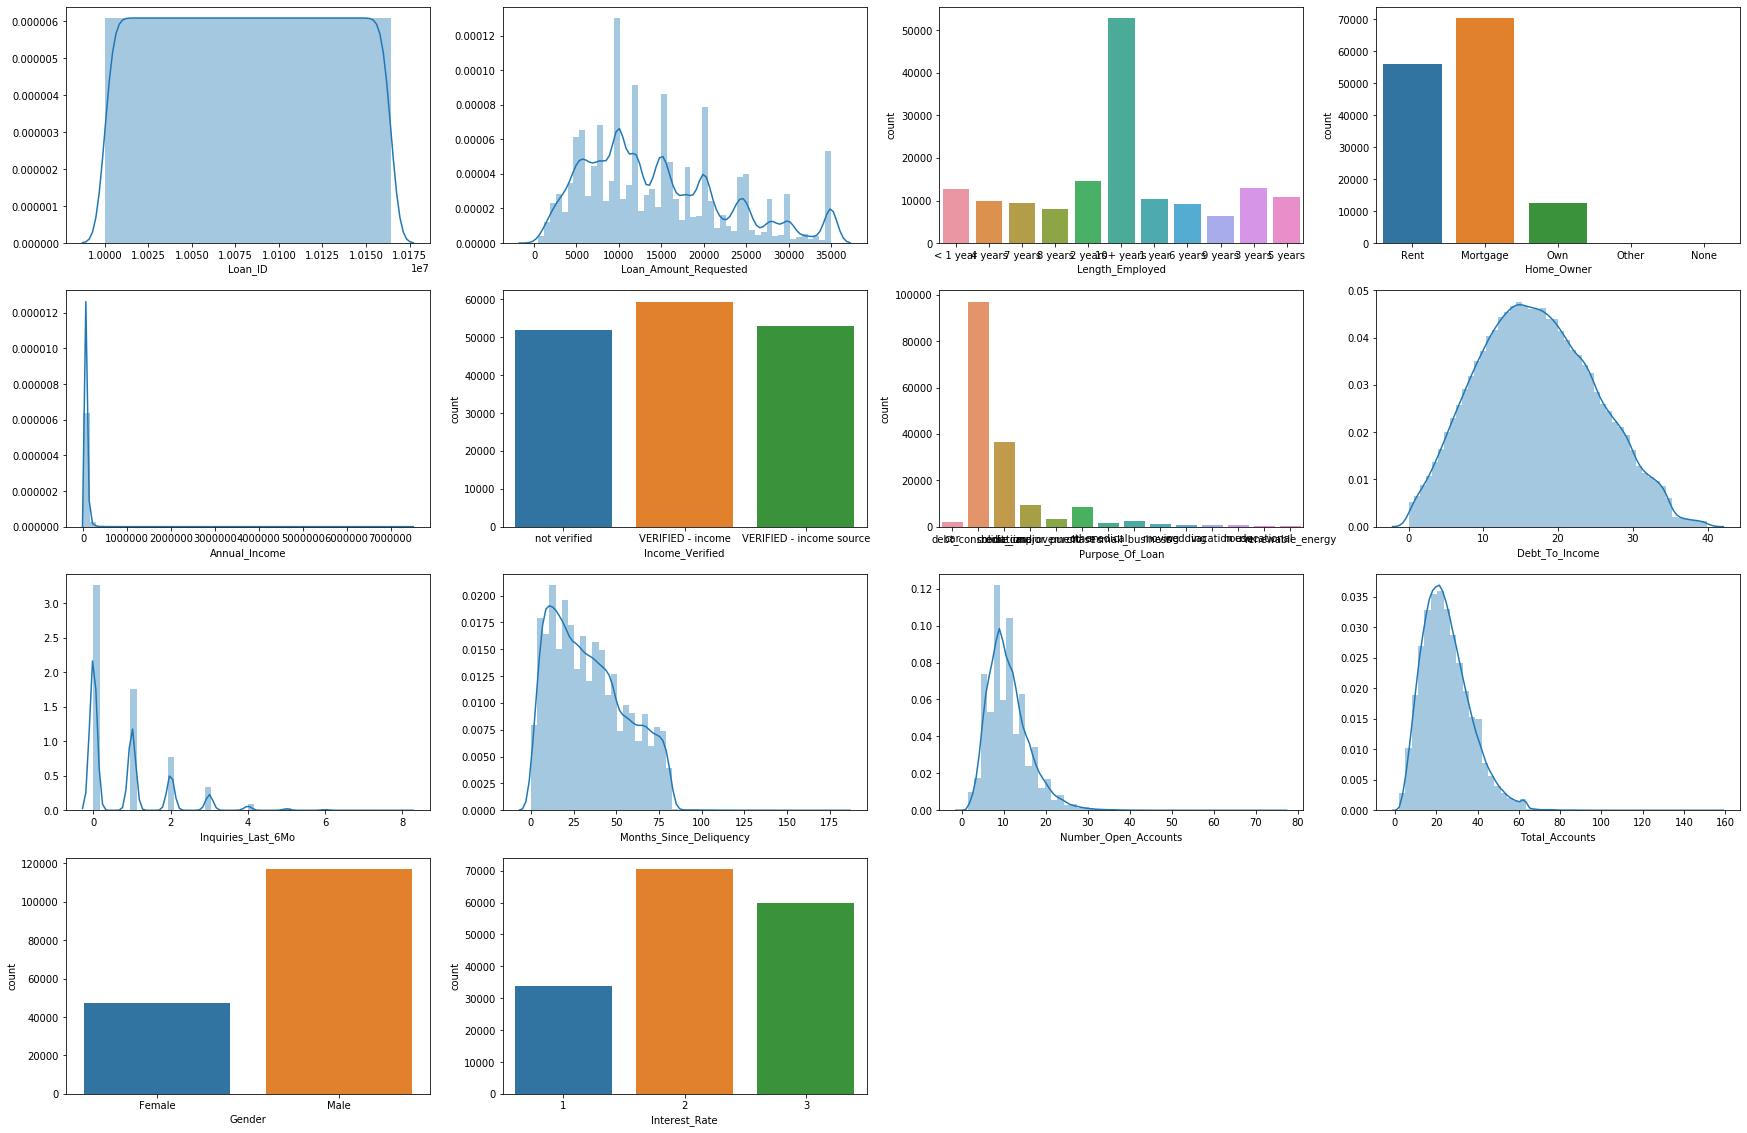

In [16]:
import seaborn as sns
plt.figure(figsize= (30,20))  
pos = 1 
for feature in train_df.columns:   
    plt.subplot(4, 4, pos)   
    if feature in num_cols:   
        sns.distplot(train_df[feature], kde= True )
    else:
        sns.countplot(train_df[feature])
    pos += 1 

Loan_ID                       AxesSubplot(0.125,0.657941;0.227941x0.222059)
Loan_Amount_Requested      AxesSubplot(0.398529,0.657941;0.227941x0.222059)
Annual_Income              AxesSubplot(0.672059,0.657941;0.227941x0.222059)
Debt_To_Income                AxesSubplot(0.125,0.391471;0.227941x0.222059)
Inquiries_Last_6Mo         AxesSubplot(0.398529,0.391471;0.227941x0.222059)
Months_Since_Deliquency    AxesSubplot(0.672059,0.391471;0.227941x0.222059)
Number_Open_Accounts             AxesSubplot(0.125,0.125;0.227941x0.222059)
Total_Accounts                AxesSubplot(0.398529,0.125;0.227941x0.222059)
Interest_Rate                 AxesSubplot(0.672059,0.125;0.227941x0.222059)
dtype: object

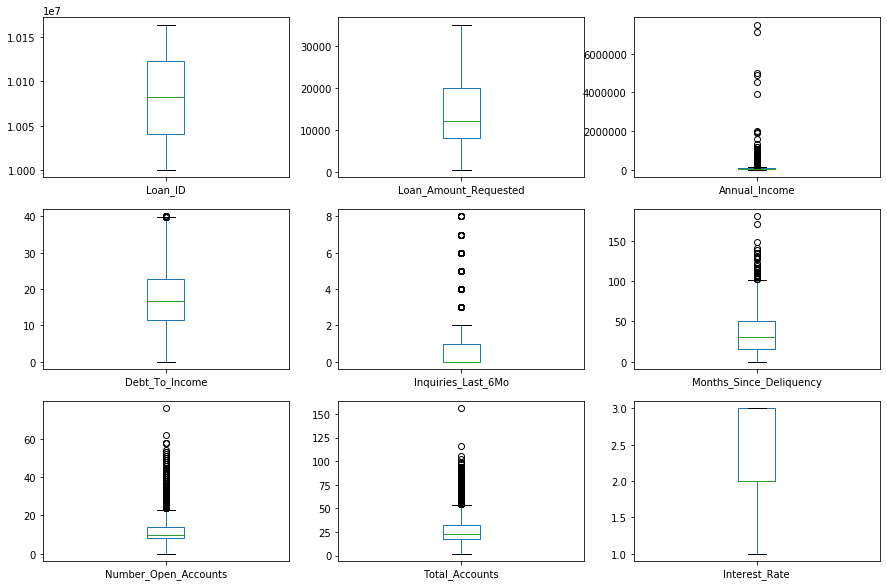

In [17]:
train_df.plot(kind= 'box' , subplots=True,layout=(3,3), sharex=False, sharey=False, figsize=(15,10))

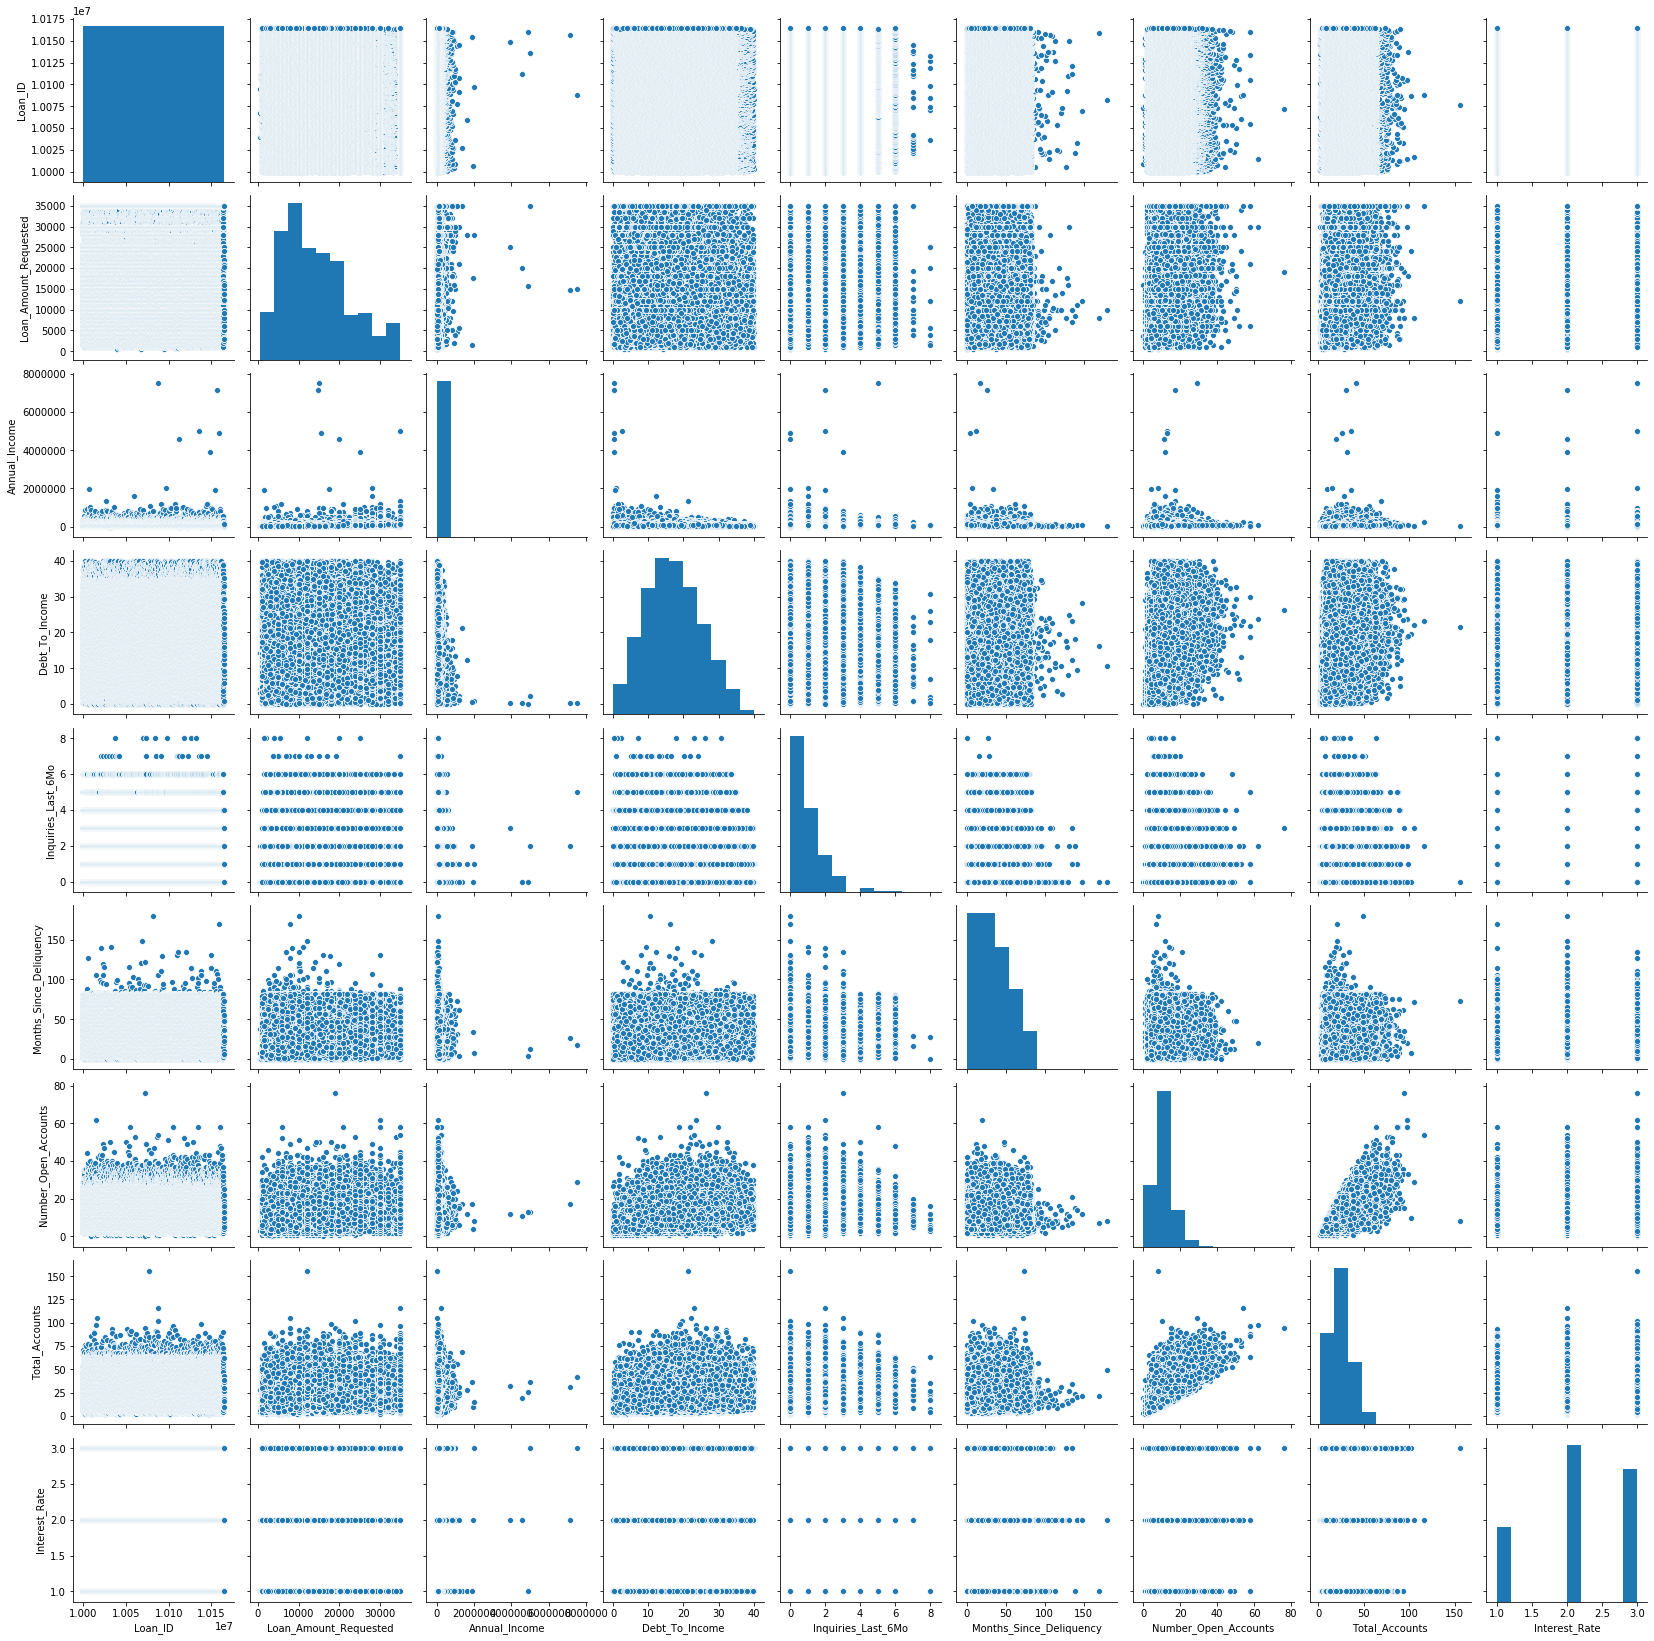

In [18]:
sns.pairplot(train_df)

In [19]:
CAT

['Gender',
 'Home_Owner',
 'Income_Verified',
 'Length_Employed',
 'Loan_Amount_Requested',
 'Purpose_Of_Loan']

In [20]:
cat_cols = CAT

nunique_dict = {}
for c in cat_cols:
    nunique_dict[c] = train_df[c].nunique()
    print(c + ': %d values' % nunique_dict[c])

Gender: 2 values
Home_Owner: 5 values
Income_Verified: 3 values
Length_Employed: 11 values
Loan_Amount_Requested: 1290 values
Purpose_Of_Loan: 14 values


In [21]:
cat_unique=[]
for cat in CAT:
    a=pd.unique(train_df[cat])
    if len(a)>1 and len(a)<500:
        cat_unique.append(cat)
cat_unique  

['Gender',
 'Home_Owner',
 'Income_Verified',
 'Length_Employed',
 'Purpose_Of_Loan']

In [22]:
for cat in cat_unique:
    x=pd.value_counts(train_df[cat])
    x=pd.DataFrame(x)
    x['percentage']=x/len(train_df)
    x['var']=cat
    x['category']=x.index.values
    x.columns=['count','percentage','var','category']
    if cat==cat_unique[0]:
        freq_table=x
    else:
        freq_table=x.append([freq_table])
freq_table

,count,percentage,var,category
debt_consolidation,97101,0.590966,Purpose_Of_Loan,debt_consolidation
credit_card,36684,0.223262,Purpose_Of_Loan,credit_card
home_improvement,9269,0.056412,Purpose_Of_Loan,home_improvement
other,8346,0.050795,Purpose_Of_Loan,other
major_purchase,3435,0.020906,Purpose_Of_Loan,major_purchase
small_business,2392,0.014558,Purpose_Of_Loan,small_business
car,1885,0.011472,Purpose_Of_Loan,car
medical,1541,0.009379,Purpose_Of_Loan,medical
moving,974,0.005928,Purpose_Of_Loan,moving
vacation,837,0.005094,Purpose_Of_Loan,vacation


In [23]:
train_df.head(3)

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,7000,< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,30000,4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,24725,7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3


In [24]:
for col in num_cols:
    train_df[col]=pd.to_numeric(train_df[col], errors='coerce')
    test_df[col]=pd.to_numeric(test_df[col], errors='coerce')

In [25]:
cat_unique

['Gender',
 'Home_Owner',
 'Income_Verified',
 'Length_Employed',
 'Purpose_Of_Loan']

In [26]:
cols_for_lbl=['Income_Verified','Length_Employed','Purpose_Of_Loan']

In [30]:
for col in cols_for_lbl:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

In [31]:
cols_for_ohe=['Gender','Home_Owner']

In [36]:
train_df['Gender']=pd.get_dummies(train_df['Gender'])
test_df['Gender']=pd.get_dummies(test_df['Gender'])

train_df['Home_Owner']=pd.get_dummies(train_df['Home_Owner'])
test_df['Home_Owner']=pd.get_dummies(test_df['Home_Owner'])


In [37]:
train_df.columns

Index(['Loan_ID', 'Loan_Amount_Requested', 'Length_Employed', 'Home_Owner',
       'Annual_Income', 'Income_Verified', 'Purpose_Of_Loan', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Months_Since_Deliquency', 'Number_Open_Accounts',
       'Total_Accounts', 'Gender', 'Interest_Rate'],
      dtype='object')

In [38]:
missing_colums=['Annual_Income', 'Home_Owner','Length_Employed']

In [39]:
def impute_na(df, variable, impute_value):
    df[variable] = df[variable].fillna(impute_value)
    

In [40]:
impute_income = train_df.Annual_Income.median()
impute_income

63000.0

In [41]:
impute_na(train_df, 'Annual_Income', impute_income)
impute_na(test_df, 'Annual_Income', impute_income)


In [42]:
impute_owner=train_df.Home_Owner.mode()
impute_owner

0    0
dtype: uint8

In [43]:
impute_na(train_df, 'Home_Owner', impute_owner)
impute_na(test_df, 'Home_Owner', impute_owner)

In [44]:
impute_Employed=train_df.Length_Employed.mode()
impute_Employed

0    1
dtype: int64

In [45]:
impute_na(train_df, 'Length_Employed', impute_Employed)
impute_na(test_df, 'Length_Employed', impute_Employed)

In [46]:
X_train=train_df.drop(['Months_Since_Deliquency','Loan_ID','Interest_Rate'],axis=1)
y_train=train_df['Interest_Rate']

In [47]:
X_test=test_df.drop(['Months_Since_Deliquency','Loan_ID'],axis=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 10.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
submission_df['Interest_Rate']=pd.DataFrame(pred_val)

In [ ]:
submission_df.to_csv('sample_submission_HSqiq1Q.csv', index=False)

In [ ]:
submission_df.head(5)